# Batch Normalization(Tensorflow)

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from miniBatch import random_mini_batche  
from data_utils import get_CIFAR10_data
from tensorflow.python.framework import ops
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"]='3'

### Load Data

这里我们使用CIFAR10的数据集,由于数据量较多,我们取

训练样本:2000

验证样本:100

测试样本:100

In [2]:
# Load the (preprocessed) CIFAR10 data.
data = get_CIFAR10_data()
for k, v in data.items():
    print('%s: ' % k, v.shape)

X_train:  (49000, 3, 32, 32)
y_train:  (49000,)
X_val:  (1000, 3, 32, 32)
y_val:  (1000,)
X_test:  (1000, 3, 32, 32)
y_test:  (1000,)


In [3]:
def load_data(index_train,index_val,index_test):
    train_x = data['X_train'][:index_train].reshape(index_train,-1)
    train_y = data['y_train'][:index_train]
    
    val_x = data['X_val'][:index_val].reshape(index_val,-1)
    val_y = data['y_val'][:index_val]
    
    test_x = data['X_test'][:index_test].reshape(index_test,-1)
    test_y = data['y_test'][:index_test]
    
    return train_x,train_y,val_x,val_y,test_x,test_y

In [4]:
train_x,train_y,val_x,val_y,test_x,test_y = load_data(2000,100,100)

### Build Tensorflow Model

这里我们主要实用Python类的方式创建BN网络.

由于我们需要将BN与普通网络进行对比,所以实际上搭建Forward有两种情况:

(1) batchNormal:

```python
if self.mode == 'batchNormal':
    ...```
    
**Note:**

A.在使用TF搭建BN的Forward时我们需要使用[tf.layers.batch_normalization](https://www.tensorflow.org/versions/r1.10/api_docs/python/tf/layers/batch_normalization?hl=en),而这个函数是有点坑的,一定需要指定一个参数:```training```,如果为True,则代表训练,False表示测试.

B.```axis```,需要指定的是特征轴.

C.使用TF的BN网络时候,除了在之后定义cost,optimizer,根据官方文档提供的信息,还需要建立```tf.GraphKeys.UPDATE_OPS```,用于更新Graph.

<img src="../../../picture/57.png" width=500 heigth="500">

<img src="../../../picture/58.png" width=500 heigth="500">
    
(2) baseline:

```python
elif self.mode == "baseline":
    ...```

普通的DNN就与往常一样.

### Functions

(1) 

```python
def __init__(self,layers,lr,epochs,mode='batchNormal',print_step=100,is_print=False):
    ...```

此函数为类Model的初始化其中

(1.1) self.mode:控制模型运行BN网络还是Baseline网络

(1.2) self.layers: 各个层的神经元节点

(1.3) self.lr: 学习率

(1.4) self.seed: 随机数种子,用于控制mini-batch

(1.5) self.epochs: 迭代次数

(1.6) self.print_step: 在迭代过程中打印间隔

(1.7) self.is_print: 在迭代过程中是否打印输出

-------------

(2) 

```python
def forward(self,X):
    ...```
    
(2.1) 

```python
if self.mode == 'batchNormal':
    ...```
    
选择BN网络:

> 初始化$W$:```W = tf.get_variable(...)```,初始化值选择Xavier.

> 计算线行值$Z$:```Z = tf.matmul(A,W)```

> 进入BN层:```tf.layers.batch_normalization(...)```,需要注意的是这里的```training=self.is_fit```参数如果为True则是训练,False为测试.使用```self.is_fit```来控制.

> axis选择特征轴.

> 使用ReLu激活函数```A = tf.nn.relu(Z_hat)```.

(2.2)

```python
elif self.mode == "baseline":
    ...```

选择普通网络:

> 初始化$W$:```W = tf.get_variable(...)```,初始化值选择Xavier.

> 初始化$b$:```b = tf.Variable(...)```,初始化值为0.

> 计算线行值$Z$:```Z = tf.add(tf.matmul(A,W),b)```.

> 使用ReLu激活函数```A = tf.nn.relu(Z)```.


(3) 

```python
def fit(self,data,labels,val_data,val_labels,batch_size=64):
    ...```

> 此函数中,需要注意的是如果走BN,需要设定:```with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):```

> 由于我们的score函数是和fit函数分开的所以我们需要使用```tf.Session().as_default()```来保证当训练完成的时候Graph不是处于关闭状态,这样score才能够调用.

> 更多详情:1.[tf.Session()和tf.Session().as_default()的区别](https://blog.csdn.net/Enchanted_ZhouH/article/details/77571939),2.[stackoverflow](https://stackoverflow.com/questions/40785224/tensorflow-cannot-interpret-feed-dict-key-as-tensor)





In [5]:
class Model:
    """
    TF of NN.
    """
    def __init__(self,layers,lr,epochs,mode='batchNormal',print_step=100,is_print=False):
        """
        Initialization class Model.
        """
        ops.reset_default_graph()
        self.mode = mode
        self.layers = layers
        self.lr = lr
        self.seed = 0
        self.epochs = epochs
        self.print_step = print_step
        self.is_print = is_print

    
    def forward(self,X):
        """
        Build forward
        
        Parameters:
        -----------
            X: input layer data.
        Returns:
        -------
            Z_hat: if using BN.
            Z: if using baseline.
        
        Note:
        -----
            if using BN,the make sure training is true
        """
        self.layers.insert(0,self.n)
        self.L = len(layers) # #layers plus input layer features.
        
        if self.mode == 'batchNormal':
            
            A = X
            for l in range(1,self.L):
                
                W = tf.get_variable('W'+str(l),[self.layers[l-1],self.layers[l]],
                                   initializer=tf.contrib.layers.xavier_initializer(seed=0))
                Z = tf.matmul(A,W)
                ########################## core processing of BN part ###############
                Z_hat = tf.layers.batch_normalization(Z,axis=1,training=self.is_fit)
                #############################  end #################################
                if l != self.L-1:
                    A = tf.nn.relu(Z_hat)
            return Z_hat
          
        elif self.mode == "baseline":
            
            A = X
            for l in range(1,self.L):
                W = tf.get_variable('W'+str(l),[self.layers[l-1],self.layers[l]],
                                   initializer=tf.contrib.layers.xavier_initializer(seed=0))
                b = tf.Variable(tf.zeros([1,self.layers[l]],name='b'+str(l)))
            
                Z = tf.add(tf.matmul(A,W),b)
                if l != self.L-1:
                    A = tf.nn.relu(Z)
            return Z
        else:
            print('Error model {}'.format(self.mode))
    
    def fit(self,data,labels,val_data,val_labels,batch_size=64):
        """
        fitting model
        Parameters:
        ----------
            data: training data.
            labels: training labels.
            val_data: verification data.
            val_labels:verification labels.
            batch_size: sample batch size default 64.
            
        Returns:
        -------
            costs: training data loss.
            acc_trains: correct rate train data.
            acc_vals: correct rate verify data.
        
        """
        ################ create place holder ####################
        self.classes = len(np.unique(labels))
        self.m,self.n = data.shape
        self.is_fit = tf.placeholder(tf.bool,name='is_fit') # control BN layer is training or testing
        self.X = tf.placeholder(tf.float32,[None,self.n],name='X')
        y = tf.placeholder(tf.float32,[None,self.classes],name='y')
        self.acc_y = tf.placeholder(tf.int64,[None,],name='acc_y')
        #################  end of create placeholder ############
        
        ######### start forward ######
        self.Z = self.forward(self.X)
        ######### end of forward #####
        
        
        #################### create cost and using softmax cross entropy ##############################
        cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=self.Z,labels=y,axis=1))
        ############################# end of cost ####################
        
        
        ######################## BN layer ############################
        if self.mode == 'batchNormal':
            with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
                optimizer = tf.train.GradientDescentOptimizer(learning_rate=self.lr).minimize(cost)
        ####################### end of BN layer ######################
        
        
        ###################### base layer ############################
        else:
            optimizer = tf.train.GradientDescentOptimizer(learning_rate=self.lr).minimize(cost)
        ###################### end of base layer #####################
        
        
        ################ caculate accuracy ###########################
        predict_y = tf.nn.softmax(logits=self.Z,axis=1)
        correct_ = tf.equal(tf.argmax(predict_y,axis=1),self.acc_y)
        self.accuracy = tf.reduce_mean(tf.cast(correct_,tf.float32))
        init = tf.global_variables_initializer()
        ################ end of caculate accuracy ####################
            
        
        ########## start running Model ########
        with tf.Session().as_default() as self.sess:
            
            self.sess.run(init)
            costs = []
            acc_trains = []
            acc_vals = []
            
            for epoch in range(self.epochs):
                self.seed = self.seed + 1
                miniBatchs = random_mini_batche(data,labels,seed=self.seed,mini_batche_size=batch_size)
                for batch in miniBatchs:
                    (mini_batche_X,mini_batche_Y) = batch
                    mini_batche_Y_hot = np.eye(self.classes)[mini_batche_Y]
                    _,loss = self.sess.run([optimizer,cost],feed_dict={self.X:mini_batche_X,
                                                                  y:mini_batche_Y_hot,
                                                                self.is_fit:True}) # self.is_fit euqal true,important!
                    
                ######################## testing with self.print_step ###################
                if epoch % self.print_step == 0 and self.is_print:
                    if self.mode == 'batchNormal':
                        acc_train = self.sess.run(self.accuracy,feed_dict={self.X:data,self.acc_y:labels,
                                                                      self.is_fit:False})
                        acc_val = self.sess.run(self.accuracy,feed_dict={self.X:val_data,self.acc_y:val_labels,
                                                                    self.is_fit:False})
                        print('mode:{} After {} loss:{} train acc:{} val acc:{}'.format(self.mode,
                                                                                        epoch,loss,acc_train,acc_val))
                    else:
                        acc_train = self.sess.run(self.accuracy,feed_dict={self.X:data,self.acc_y:labels})
                        acc_val = self.sess.run(self.accuracy,feed_dict={self.X:val_data,self.acc_y:val_labels})
                        print('mode:{} After {} loss:{} train acc:{} val acc:{}'.format(self.mode,
                                                                                        epoch,loss,acc_train,acc_val))
                    # cache loss,acc_train,acc_val
                    costs.append(loss)
                    acc_trains.append(acc_train)
                    acc_vals.append(acc_val)
            
            return costs,acc_trains,acc_vals
            
    
    def score(self,data,labels):
        """
        build score function
        Parameters:
        ----------
            data: score data set.
            labels: score labels.
        Return:
        ------
            acc_: data correct rate.
        """
        if self.mode == 'batchNormal':
            acc_ = self.sess.run(self.accuracy,feed_dict={self.X:data,self.acc_y:labels,
                                                              self.is_fit:False})
        else:
            acc_ = self.sess.run(self.accuracy,feed_dict={self.X:data,self.acc_y:labels})
        
        return acc_
    
    def close_sess(self):
        """
        close the sess.
        """
        self.sess.close()

### Testing BN and BaseLine

测试不同情况下,BN网络与普通网络之间的差异:

(1) 小权重,小学习率

(2) 小权重,大学习率


In [6]:
def plot_(costs_bn,costs,cache_acc_train_bn,cache_acc_train,cache_acc_val_bn,cache_acc_val):
    fig=plt.figure(figsize=(20,4))
    ax1=fig.add_subplot(1,3,1)      
    ax1.plot(costs_bn,c='orange',label='batch normal')
    ax1.plot(costs,label='base line')
    ax1.set_title('Loss:batch normal & base line')
    ax1.set_xlabel('#epoch')
    ax1.set_ylabel('Value')
    ax1.legend()

    ax2 =fig.add_subplot(1,3,2)      
    ax2.plot(cache_acc_train_bn,c='orange',label='batch normal')
    ax2.plot(cache_acc_train,label='base line')
    ax2.set_title('Train acc:batch normal & base line')
    ax2.set_xlabel('#epoch')
    ax2.set_ylabel('Value')
    ax2.legend()

    ax3 =fig.add_subplot(1,3,3)      
    ax3.plot(cache_acc_val_bn,c='orange',label='batch normal')
    ax3.plot(cache_acc_val,label='base line')
    ax3.set_title('Val acc:batch normal & base line')
    ax3.set_xlabel('#epoch')
    ax3.set_ylabel('Value')
    ax3.legend()

    plt.show()

#### 小权重,小学习率

In [7]:
layers = [100, 80,50,30,10]
model = Model(layers=layers,lr=0.001,epochs=1000,is_print=True,mode='batchNormal')

In [8]:
costs_bn,cache_acc_train_bn,cache_acc_val_bn = model.fit(data=train_x,labels=train_y,
                                            val_data=val_x,val_labels=val_y,
                                           batch_size=32)


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use keras.layers.batch_normalization instead.
Instructions for updating:
Use tf.cast instead.
mode:batchNormal After 0 loss:2.4829797744750977 train acc:0.1354999989271164 val acc:0.12999999523162842
mode:batchNormal After 100 loss:0.9941392540931702 train acc:0.9700000286102295 val acc:0.2800000011920929
mode:batchNormal After 200 loss:0.5647058486938477 train acc:0.9975000023841858 val acc:0.3199999928474426
mode:batchNormal After 300 loss:0.647903323173523 train acc:0.9994999766349792 val acc:0.3799999952316284
mode:batchNormal After 400 loss:0.5113117694854736 train acc:1.0 val acc:0.3799999952316284
mode:batchNormal After 500 loss:0.3247058391571045 tr

In [9]:
model.close_sess()

In [10]:
layers = [100, 80,50,30,10]
model = Model(layers=layers,lr=0.001,epochs=1000,is_print=True,mode='baseline')

In [11]:
costs,cache_acc_train,cache_acc_val = model.fit(data=train_x,labels=train_y,
                                            val_data=val_x,val_labels=val_y,
                                           batch_size=32)

mode:baseline After 0 loss:4.26552677154541 train acc:0.2280000001192093 val acc:0.12999999523162842
mode:baseline After 100 loss:0.17357733845710754 train acc:0.9039999842643738 val acc:0.2199999988079071
mode:baseline After 200 loss:0.01228276640176773 train acc:0.9775000214576721 val acc:0.23999999463558197
mode:baseline After 300 loss:0.14997310936450958 train acc:0.9884999990463257 val acc:0.2199999988079071
mode:baseline After 400 loss:0.003139659995213151 train acc:0.9929999709129333 val acc:0.23999999463558197
mode:baseline After 500 loss:0.11844131350517273 train acc:0.9944999814033508 val acc:0.25
mode:baseline After 600 loss:0.0004344613407738507 train acc:0.9944999814033508 val acc:0.25
mode:baseline After 700 loss:0.0013919182820245624 train acc:0.9944999814033508 val acc:0.25
mode:baseline After 800 loss:0.0007034075679257512 train acc:0.9959999918937683 val acc:0.27000001072883606
mode:baseline After 900 loss:0.0004991373280063272 train acc:0.9980000257492065 val acc:0.2

In [12]:
model.close_sess()

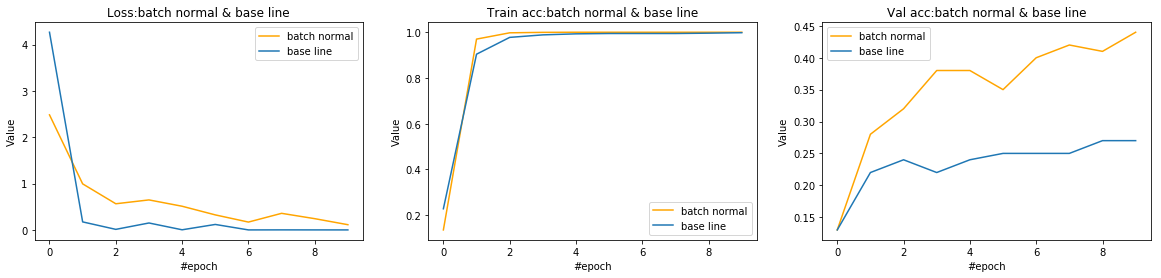

In [13]:
plot_(costs_bn,costs,cache_acc_train_bn,cache_acc_train,cache_acc_val_bn,cache_acc_val)

可以看到,在小学习率,小权重下,BN网络的收敛速度更快,且正确率要高于BaseLine.

#### 小权重,大学习率

In [14]:
layers = [100, 80,50,30,10]
model = Model(layers=layers,lr=0.1,epochs=1000,is_print=True,mode='batchNormal')

In [15]:
costs_bn,cache_acc_train_bn,cache_acc_val_bn = model.fit(data=train_x,labels=train_y,
                                            val_data=val_x,val_labels=val_y,
                                           batch_size=32)

mode:batchNormal After 0 loss:1.8434940576553345 train acc:0.31150001287460327 val acc:0.25999999046325684
mode:batchNormal After 100 loss:0.4368012249469757 train acc:0.9714999794960022 val acc:0.3799999952316284
mode:batchNormal After 200 loss:0.09758403897285461 train acc:1.0 val acc:0.38999998569488525
mode:batchNormal After 300 loss:0.023914558812975883 train acc:1.0 val acc:0.38999998569488525
mode:batchNormal After 400 loss:0.1798146516084671 train acc:1.0 val acc:0.46000000834465027
mode:batchNormal After 500 loss:0.008287171833217144 train acc:1.0 val acc:0.4300000071525574
mode:batchNormal After 600 loss:0.03266455978155136 train acc:0.9994999766349792 val acc:0.49000000953674316
mode:batchNormal After 700 loss:0.16134804487228394 train acc:0.9929999709129333 val acc:0.3700000047683716
mode:batchNormal After 800 loss:0.0024501858279109 train acc:1.0 val acc:0.4099999964237213
mode:batchNormal After 900 loss:0.0033638374879956245 train acc:1.0 val acc:0.38999998569488525


In [16]:
model.close_sess()

In [17]:
layers = [100, 80,50,30,10]
model = Model(layers=layers,lr=0.1,epochs=1000,is_print=True,mode='baseline')

In [18]:
costs,cache_acc_train,cache_acc_val = model.fit(data=train_x,labels=train_y,
                                            val_data=val_x,val_labels=val_y,
                                           batch_size=32)

mode:baseline After 0 loss:nan train acc:0.10100000351667404 val acc:0.07000000029802322
mode:baseline After 100 loss:nan train acc:0.10100000351667404 val acc:0.07000000029802322
mode:baseline After 200 loss:nan train acc:0.10100000351667404 val acc:0.07000000029802322
mode:baseline After 300 loss:nan train acc:0.10100000351667404 val acc:0.07000000029802322
mode:baseline After 400 loss:nan train acc:0.10100000351667404 val acc:0.07000000029802322
mode:baseline After 500 loss:nan train acc:0.10100000351667404 val acc:0.07000000029802322
mode:baseline After 600 loss:nan train acc:0.10100000351667404 val acc:0.07000000029802322
mode:baseline After 700 loss:nan train acc:0.10100000351667404 val acc:0.07000000029802322
mode:baseline After 800 loss:nan train acc:0.10100000351667404 val acc:0.07000000029802322
mode:baseline After 900 loss:nan train acc:0.10100000351667404 val acc:0.07000000029802322


In [19]:
model.close_sess()

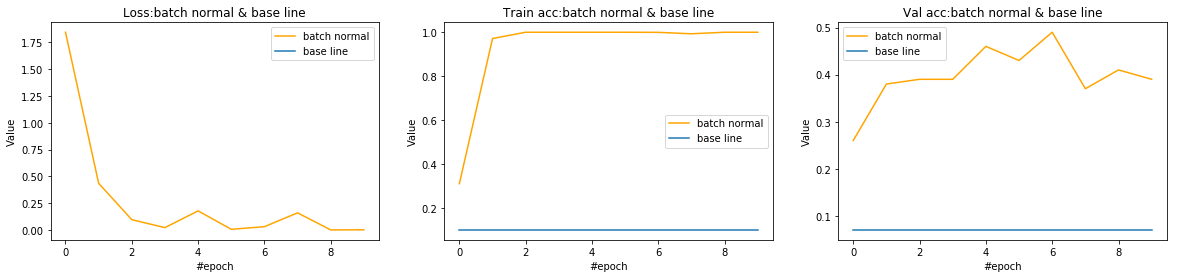

In [20]:
plot_(costs_bn,costs,cache_acc_train_bn,cache_acc_train,cache_acc_val_bn,cache_acc_val)

在小权重,大学习率下,BN网络收敛速度快而BaseLine网络直接产生梯度消失的情况,说明BN网络确实一定程度解决了随着网络变深梯度消失的情况.

# Summary

总体而言BN网络比BaseLine网络更加优秀,但是我在网上发现,有些人认为越大的Batch Size网络会更好,但是我这里的数据集显示并非一定如此,当然这仅代表个人观点.